# Melanoma Detection using CNN

---

In this project, I'll be working on a deep learning pipeline that processes the input images of possible melanomic moles/tumors and predicts the probability of the mole(s) being melanomous.

***
Melanoma, also known as malignant melanoma, is a type of skin cancer that develops from the pigment-producing cells known as melanocytes. Melanomas typically occur in the skin but may rarely occur in the mouth, intestines or eyes.
About 25% of melanomas develop from moles. Changes in a mole that can indicate melanoma include an increase in size, irregular edges, change in color, itchiness or skin breakdown.

The primary cause of melanoma is ultraviolet light (UV) exposure in those with low levels of the skin pigment melanin. The UV light may be from the sun or other sources, such as tanning devices. Those with many moles, a history of affected family members and poor immune function are at greater risk. A number of rare genetic conditions such as xeroderma pigmentosum also increase the risk.Diagnosis is by biopsy and analysis of any skin lesion that has signs of being potentially cancerous.
— Source: [Wikipedia](https://en.wikipedia.org/wiki/Melanoma#:~:text=Melanoma%2C%20also%20known%20as%20malignant,or%20eye%20(uveal%20melanoma).)

Also check out [this page on SkinCancer.org](https://www.skincancer.org/skin-cancer-information/melanoma/) to know more about melanoma.
***

Melanoma is one of the most aggressive forms of skin cancer. Hence, a highly efficient model capable of early detection of melanoma can prove to be a life saviour.

***

## Importing Project Dependencies
---

This notebook will be dedicated to the EDA of the training data. So we will import the dependencies accordingly. 

In [1]:
import os
import torch
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image

from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid

## EDA

---

Now, let us perform some exploratory data analysis on the training set. The first step for this project section is cleaning the data. Let us load the train.csv file and see if the data needs any cleaning.

In [2]:
train_df = pd.read_csv('../input/siim-isic-melanoma-classification/train.csv')
train_df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


Now, we don't need the column 'patient_id', so we will drop it.

In [3]:
train_df.drop(columns = ['patient_id'], axis = 1, inplace = True)
train_df.head()

,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,female,55.0,upper extremity,unknown,benign,0


Now, let us check for the missing values in our dataframe. 

In [4]:
null_df = train_df.isnull().sum().to_frame()
null_df.columns = ['null_vals']
null_df['percent_null'] = null_df['null_vals']/len(train_df)
null_df

,null_vals,percent_null
image_name,0,0.000000
sex,65,0.001962
age_approx,68,0.002053
anatom_site_general_challenge,527,0.015909
diagnosis,0,0.000000
benign_malignant,0,0.000000
target,0,0.000000


As we can see, around 0.002% values are missing in the 'sex' column, and around the same number is missing from the 'age_approx' column. In case of the 'anatom_site_general_challenge' column, the number is slightly higher, around 0.01%. However, since these numbers are very small as compared to the actual size of the dataset, we will simply drop these null values from our dataframe. 

*One thing to be noted here is that we are only dropping these values for the EDA part. While training the model, these null values won't make any difference since all the images and the target values are all present.*

In [5]:
EDA_df = train_df.dropna()
len(EDA_df), len(train_df)

(32531, 33126)

Now that we have cleaned our dataset, let us move on to performing the EDA on our data.

Percentage of different diagnosed mole types:


unknown                               81.737420
nevus                                 15.821831
melanoma                               1.767545
seborrheic keratosis                   0.399619
lentigo NOS                            0.135256
lichenoid keratosis                    0.110664
solar lentigo                          0.021518
cafe-au-lait macule                    0.003074
atypical melanocytic proliferation     0.003074
Name: diagnosis, dtype: float64

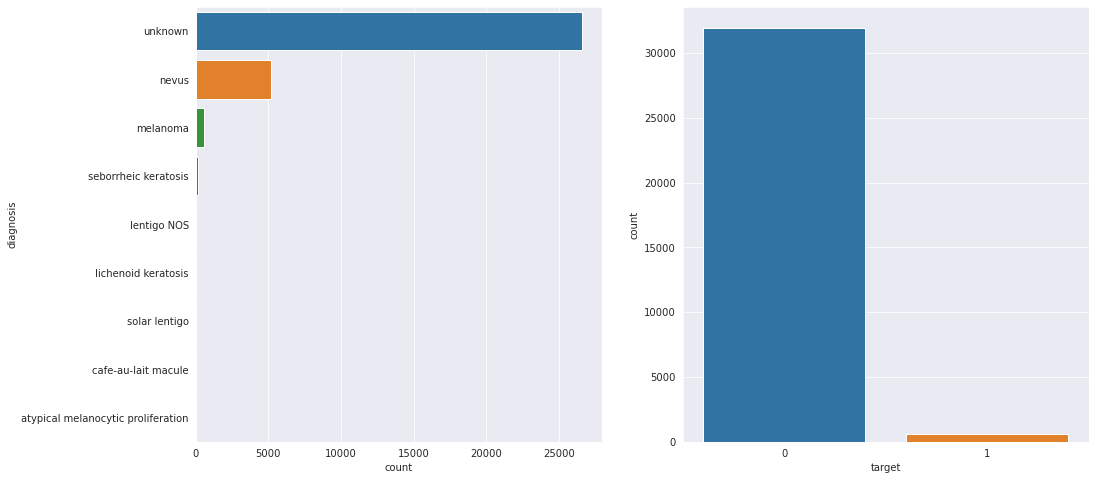

In [6]:
sns.set_style('darkgrid')

f, ax = plt.subplots(1, 2, figsize = (16, 8))
sns.countplot(y = 'diagnosis', data = EDA_df, ax = ax[0])
sns.countplot(x = 'target', data = EDA_df, ax = ax[1])

f.show()

print('Percentage of different diagnosed mole types:')
EDA_df['diagnosis'].value_counts() / len(EDA_df) * 100

The primary observation from the above graphs is that most of the cases (more than 80%) that we have in our training dataset don't have a certain diagnosis, i.e., their diagnosis is unknown.

Also, the percentage of confirmed diagnosed cases of melanoma is only around 1.75% of the total data. This shows that our dataset has a very high sampling bias in terms of the target variable.

Now, let us perform some EDA on the data with confirmed melanoma cases.

In [7]:
target_grouped = EDA_df.groupby('target')
confirmed_df = target_grouped.get_group(1)
confirmed_df

,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
91,ISIC_0149568,female,55.0,upper extremity,melanoma,malignant,1
235,ISIC_0188432,female,50.0,upper extremity,melanoma,malignant,1
314,ISIC_0207268,male,55.0,torso,melanoma,malignant,1
399,ISIC_0232101,male,65.0,torso,melanoma,malignant,1
459,ISIC_0247330,female,65.0,lower extremity,melanoma,malignant,1
...,...,...,...,...,...,...,...
32969,ISIC_9955163,male,55.0,upper extremity,melanoma,malignant,1
33000,ISIC_9963177,male,70.0,torso,melanoma,malignant,1
33014,ISIC_9967383,male,60.0,upper extremity,melanoma,malignant,1
33050,ISIC_9978107,male,65.0,lower extremity,melanoma,malignant,1


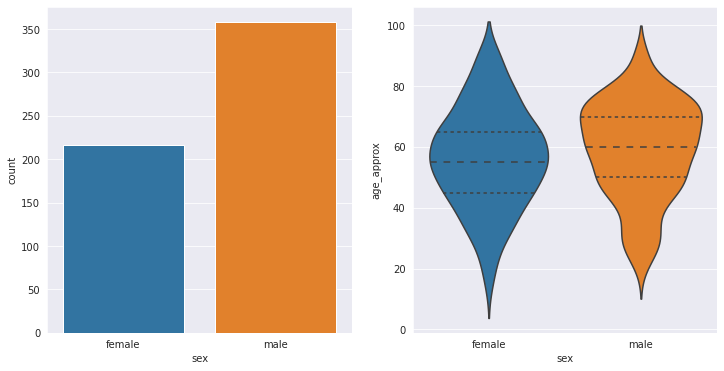

In [8]:
f, ax = plt.subplots(1,2,figsize = (12, 6))
sns.countplot( x = 'sex', data = confirmed_df, ax = ax[0])
sns.violinplot( x = 'sex', y = 'age_approx', data = confirmed_df, inner = 'quartile', ax = ax[1])
f.show()

From the above graph, we can observe that- 
* Men tend to show a higher chance of getting melanoma, however this can again be a case of sampling bias. 
* In case of both the males and females, people aged between 40-70 fall in the high-risk bracket in terms of developing melanoma.

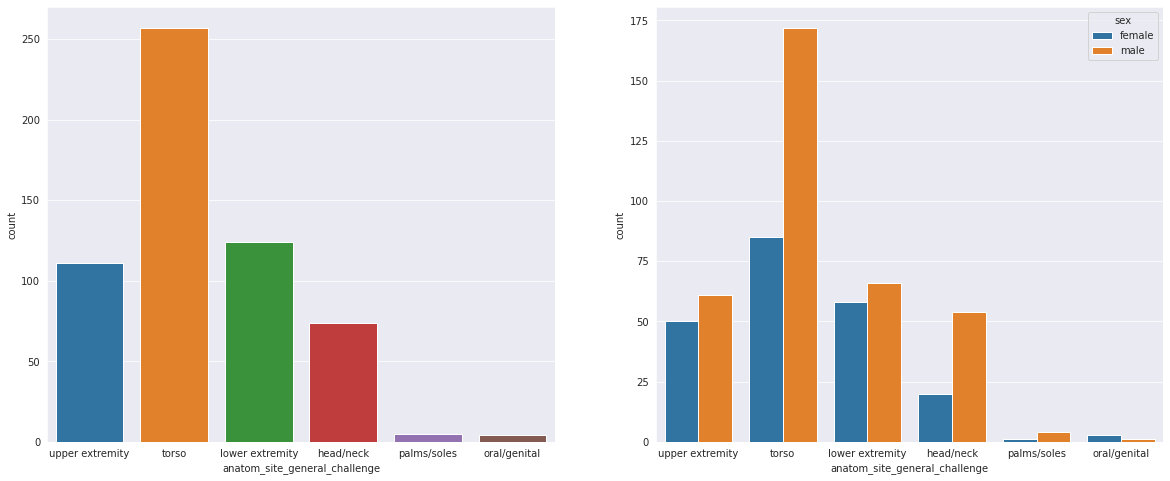

In [9]:
f, ax = plt.subplots(1, 2, figsize = (20, 8))
sns.countplot( x = 'anatom_site_general_challenge', data = confirmed_df, ax = ax[0])
sns.countplot( x = 'anatom_site_general_challenge', hue = 'sex', data = confirmed_df, ax = ax[1])
f.show()

Observations from the graphs above:
* The torso has the most number of diagnosed cases of melanoma, followed by the lower extreme and upper extreme regions of the body. However, considering the high sampling bias in our data, it can't be said with certainty that torso is the most common anatomical site for melanomous tumors/moles.
* In case of number of confirmed cases, the above graphs show that men tend to have a higher chance of developing melanoma as compared to women. 
* This trend is visible for the number of cases in almost all anatomical regions except the oral/genital region, for which women show a significantly higher number of cases as compared to men.

**NOTE**- *These are just observations made on the basis of the visualization given above. These trends may or may not represent actual statistics.*

Now that we are done with the basic EDA part, let us view a few images from our dataset.

In [44]:
sns.set_style('white')

def train_img_viewer(index):
    """Shows image in the training dataset at the random index that the user provides.
    
    Args-
        index- index of the image
    Returns-
        None
    """
    
    img_info = train_df.loc[index,['image_name', 'benign_malignant']]
    img_name = img_info.image_name + '.jpg'
    img_class = img_info.benign_malignant
    path = '../input/siim-isic-melanoma-classification/jpeg/train'
    img_path = os.path.join(path, img_name)
    img = Image.open(img_path)
    transform = transforms.ToTensor()
    img = transform(img)
    print(img_class)
    plt.imshow(img.permute(1,2,0))

benign


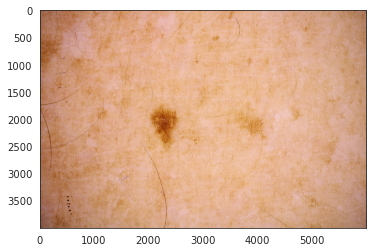

In [45]:
train_img_viewer(1)

malignant


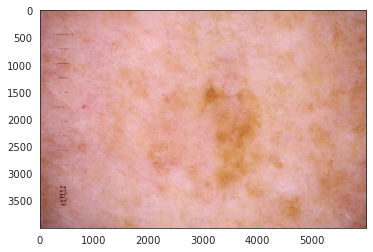

In [46]:
train_img_viewer(91)

With this, we come to the end of the first part of the project. In the next part, we will define and train our binary classification model.